In [0]:
from google.colab import drive
import os
import glob
import numpy as np  
import random  
import pandas as pd 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import normalize
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import math
import matplotlib.pyplot as plt

In [0]:
drive.mount('/content/gdrive')

In [0]:
!unzip /content/gdrive/My\ Drive/Dataset/Imbalanced_WineQualityRed/winequality_red_4_5_fold.zip > /dev/null

In [5]:
!ls 

gdrive			      winequality-red-4-5-3tra.dat
__MACOSX		      winequality-red-4-5-3tst.dat
sample_data		      winequality-red-4-5-4tra.dat
winequality-red-4-5-1tra.dat  winequality-red-4-5-4tst.dat
winequality-red-4-5-1tst.dat  winequality-red-4-5-5tra.dat
winequality-red-4-5-2tra.dat  winequality-red-4-5-5tst.dat
winequality-red-4-5-2tst.dat


## Loading 5-folds cross validation dataset

In [0]:
kFold = 5

In [7]:
traFiles = sorted(glob.glob('*tra.dat'))
tstFiles = sorted(glob.glob('*tst.dat'))
X_train = []
Y_train = []
X_test = []
Y_test = []
col_names = ['FixedAcidity', 'VolatileAcidity', 'CitricAcid', 'ResidualSugar', 'Chlorides', 'FreeSulfurDioxide', 'TotalSulfurDioxide', 'Density', 'PH', 'Sulphates', 'Alcohol', 'Class']
for traPath, tstPath in zip(traFiles, tstFiles):
  df_train = pd.read_csv(traPath, skiprows=16, names=col_names, sep=r', ')
  df_test = pd.read_csv(tstPath, skiprows=16, names=col_names, sep=r', ')
  
  X_train.append(df_train[col_names[0:11]])
  Y_train.append(df_train['Class'])

  X_test.append(df_test[col_names[0:11]])
  Y_test.append(df_test['Class'])

for i in range(kFold):
  X_train[i] = X_train[i].values.tolist() # pandas data frame to list of lists 
  X_test[i] = X_test[i].values.tolist()
  Y_train[i] = [int(y == 'negative') for y in Y_train[i]]
  Y_test[i] = [int(y == 'negative') for y in Y_test[i]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __

Minority Class Label : 0 (positive)

### A function for training, evaluating and calculating metrics:

In [0]:
def classify(model, classifier_name):
  acc = precision = recall = 0

  for i in range(kFold):
    # Training 
    model.fit(X_train[i], Y_train[i])


    # Evaluation
    y_pred = model.predict(X_test[i])

    # Result
    acc += accuracy_score(Y_test[i], y_pred)
    precision += precision_score(Y_test[i], y_pred, average='macro', zero_division=0)
    recall += recall_score(Y_test[i], y_pred, average='macro', zero_division=0)
  
  acc /= kFold
  precision /= kFold
  recall /= kFold

  print("{} Accuracy: {:.2f}".format(classifier_name, acc))
  print("{} Precision: {:.2f}".format(classifier_name, precision))
  print("{} Recall: {:.2f}".format(classifier_name, recall))

  return acc, precision, recall

## SVM

In [9]:
model = SVC(kernel ='rbf', gamma='scale', C = 1)
acc_svm, precision_svm, recall_svm = classify(model, "SVM")

SVM Accuracy: 0.97
SVM Precision: 0.48
SVM Recall: 0.50


## Random Forest

### L = 10

In [10]:
model = RandomForestClassifier(n_estimators=10, max_depth=1)
acc_RF_L10, precision_RF_L10, recall_RF_L10 = classify(model, "Random Forest L10")

Random Forest L10 Accuracy: 0.97
Random Forest L10 Precision: 0.48
Random Forest L10 Recall: 0.50


### L = 50

In [11]:
model = RandomForestClassifier(n_estimators=50, max_depth=1)
acc_RF_L50, precision_RF_L50, recall_RF_L50 = classify(model, "Random Forest L50")

Random Forest L50 Accuracy: 0.97
Random Forest L50 Precision: 0.48
Random Forest L50 Recall: 0.50


### L = 100

In [12]:
model = RandomForestClassifier(n_estimators=100, max_depth=1)
acc_RF_L100, precision_RF_L100, recall_RF_L100 = classify(model, "Random Forest L100")

Random Forest L100 Accuracy: 0.97
Random Forest L100 Precision: 0.48
Random Forest L100 Recall: 0.50


# SMOTE

In [0]:
def smote(minority_x, N, k):
  """
  T: Number of minority class samples
  N: Amount of SMOTE % (old version)
  N: Number of new syntetic data (new version consistent with RBBoost)
  k: Number of nearest neighbors
  """
  T = len(minority_x)
  # if N < 100:
  #   T = int((N/100)*T)
  #   N = 100
  # N = (int)(N/100)
  numattrs = len(minority_x[0])
  synthetic = []

  #for n in range(T):
  for n in range(N):
    i = np.random.randint(0, len(minority_x)-1)
    nnarray = get_nearest_neighbor(minority_x, minority_x[i], k)
    populate(i, N, numattrs, minority_x, nnarray, synthetic, k, n) # n is index

  return synthetic

In [0]:
def get_nearest_neighbor(minority_x, x, k):
  """
  x: data that we want to find its neighbor
  """

  distances = []
  nearest_neighbors_index = []

  for i in range(len(minority_x)):
    if minority_x[i][:] == x:
      continue
    
    # euclidean distance
    distance = np.sqrt(np.sum(np.square(np.array(x) - np.array(minority_x[i][:]))))
    distances.append([distance, i])

  distances = sorted(distances)

  # return the k nearest neighbors of x
  for i in range(k):
    nearest_neighbors_index.append(distances[i][1])

  return nearest_neighbors_index

In [0]:
def populate(i, N, numattrs, minority_x, nnarray, synthetic, k, new_index):

  #new_index = 0
  #while N != 0:
  nn = np.random.randint(1, k) # booth low and high are inclusive
  #This step chooses one of the k nearest neighbors of i

  temp = []
  for attr in range(numattrs):
    dif = minority_x[nnarray[nn]][attr] - minority_x[i][attr]
    gap = random.random()
    temp.insert(attr, minority_x[i][attr] + gap * dif)

  synthetic.insert(new_index, temp)
    #new_index += 1
    #N = N-1

  return

In [16]:
# DEBUGGING: Testing SMOTE
min_x = [X_train[0][i] for i in range(len(X_train[0])) if Y_train[0][i] == 0]
print("The number of all train objects: ", len(X_train[0]))
print("The number of minority class objects before SMOTE: ", len(min_x))

# N = |Synthetic data| = |minority class objects| * 10
X_syn = smote(min_x, N=len(min_x)*10, k=3) 
print("\nThe number of synthetic objects created from minority class objects after SMOTE:\n", len(X_syn))

# N = |Synthetic data| = 10
X_syn = smote(min_x, N=10, k=3)
print("The number of synthetic objects created from minority class objects after SMOTE:\n", len(X_syn))

The number of all train objects:  1279
The number of minority class objects before SMOTE:  42

The number of synthetic objects created from minority class objects after SMOTE:
 420
The number of synthetic objects created from minority class objects after SMOTE:
 10


## SMOTEBOOST

In [0]:
def SmoteBoost(X, Y, minority_class, n_estimators):
  """
  minority_class: 0 or 1
  n_estimators: Number of classifiers
  """

  classifier_list = []
  beta_list = []

  D = np.empty(len(X), dtype=np.float64)
  D[:] = 1. / len(X)

  for T in range(n_estimators):
    
    minority_x = [X[i] for i in range(len(X)) if Y[i] == minority_class]
    X_syn = smote(minority_x, N=len(minority_x)*10, k=5)
    Y_syn = np.full(len(X_syn), fill_value=minority_class, dtype=np.int64)

    D_syn = np.empty(len(X_syn), dtype=np.float64)
    D_syn[:] = 1. / len(X)

    new_X = np.vstack((X, X_syn))
    new_Y = np.append(Y, Y_syn)

    D = np.append(D[:len(X)], D_syn)
    D /= sum(D)

    decision_tree = DecisionTreeClassifier(max_depth=1)
    decision_tree.fit(new_X, new_Y, D)
    classifier_list.append(decision_tree)

    predict = decision_tree.predict(new_X)
    h = decision_tree.predict_proba(new_X)

    error = 0
    for i in range(len(predict)):
      if predict[i] != new_Y[i]:
        # (i,y) in B refer to objects that misclassified by classifier
        # 1 - the probality of truth class + the probality of other classes
        error = error + (D[i] * (1 - h[i][new_Y[i]] + h[i][predict[i]]))
        
    beta = error / (1 - error)
    if math.isnan(beta) or beta == 0:
      beta = 1
    beta_list.append(beta)
    
    for i in range(len(new_X)):
      # (1 - the probality of other classes + the probality of truth class) * 1/2
      w = (1 - h[i][predict[i]] + h[i][new_Y[i]]) / 2

      D[i] = D[i] * pow(beta, w)
      
    D /= sum(D)
    
  return classifier_list, beta_list


In [0]:
def SmoteBoost_predict(classifier_list, beta_list, X_test):
  classes = classifier_list[0].classes_.tolist()
  final_proba = np.zeros((len(X_test), 2))
  for t in range(len(classifier_list)):
    proba = classifier_list[t].predict_proba(X_test)
    for j in range(len(X_test)):
      proba[j] = [math.log(1 / beta_list[t]) * i for i in proba[j]]

    final_proba = final_proba + np.array(proba)

  predict_label = []
  for l in final_proba:
    predict_label.append(classes[l.tolist().index(max(l))])

  return predict_label

In [0]:
def run_SmoteBoost(n_estimators):
  acc_smoteBoost = precision_smoteBoost = recall_smoteBoost = 0

  for i in range(kFold):
    classifiers, betas = SmoteBoost(X_train[i], Y_train[i], minority_class=0, n_estimators = n_estimators)
    y_pred = SmoteBoost_predict(classifiers, betas, X_test[i])

    acc_smoteBoost += accuracy_score(Y_test[i], y_pred)
    precision_smoteBoost += precision_score(Y_test[i], y_pred, average='macro', zero_division=0)
    recall_smoteBoost += recall_score(Y_test[i], y_pred, average='macro', zero_division=0)

  acc_smoteBoost /= kFold
  precision_smoteBoost /= kFold
  recall_smoteBoost /= kFold

  print("\nL = {}: ".format(n_estimators))
  print("SmoteBoost L{} Accuracy: {:.2f}".format(n_estimators, acc_smoteBoost))
  print("SmoteBoost L{} Precision: {:.2f}".format(n_estimators, precision_smoteBoost))
  print("SmoteBoost L{} Recall: {:.2f}".format(n_estimators, recall_smoteBoost))

  return acc_smoteBoost, precision_smoteBoost, recall_smoteBoost

In [127]:
acc_smoteBoost_L10, precision_smoteBoost_L10, recall_smoteBoost_L10 = run_SmoteBoost(n_estimators=10)
acc_smoteBoost_L50, precision_smoteBoost_L50, recall_smoteBoost_L50 = run_SmoteBoost(n_estimators=50)
acc_smoteBoost_L100, precision_smoteBoost_L100, recall_smoteBoost_L100 = run_SmoteBoost(n_estimators=100)


L = 10: 
SmoteBoost L10 Accuracy: 0.86
SmoteBoost L10 Precision: 0.53
SmoteBoost L10 Recall: 0.60

L = 50: 
SmoteBoost L50 Accuracy: 0.91
SmoteBoost L50 Precision: 0.54
SmoteBoost L50 Recall: 0.60

L = 100: 
SmoteBoost L100 Accuracy: 0.90
SmoteBoost L100 Precision: 0.54
SmoteBoost L100 Recall: 0.61


## Ada-Boost M2

In [0]:
def AdaBoostM2(X, Y, n_estimators):
  """
  n_estimators: Number of classifiers
  """

  classifier_list = []
  beta_list = []

  D = np.empty(len(X), dtype=np.float64)
  D[:] = 1. / len(X) 
  """
  D must be initialized with 1/|B|
  while in classification problems with 2 classes |B| = |m| = len(X)
  """

  for T in range(n_estimators):
    
    decision_tree = DecisionTreeClassifier(max_depth=1)
    decision_tree.fit(X, Y, D)
    classifier_list.append(decision_tree)

    predict = decision_tree.predict(X)
    h = decision_tree.predict_proba(X)

    error = 0
    for i in range(len(predict)):
      if predict[i] != Y[i]: 
        # (i,y) in B refer to objects that misclassified by classifier
        # 1 - the probality of truth class + the probality of other classes
        error = error + (D[i] * (1 - h[i][Y[i]] + h[i][predict[i]]))
        
    beta = error / (1 - error)
    if math.isnan(beta) or beta == 0:
      beta = 1
    beta_list.append(beta)
    
    for i in range(len(X)):
      # (1 + the probality of truth class - the probality of other classes) * 1/2
      w = (1 + h[i][Y[i]] - h[i][predict[i]]) / 2

      D[i] = D[i] * pow(beta, w)
      
    D /= sum(D)
    
  return classifier_list, beta_list

In [0]:
def AdaBoostM2_predict(classifier_list, beta_list, X_test):
  classes = classifier_list[0].classes_.tolist()
  final_proba = np.zeros((len(X_test), 2))
  for t in range(len(classifier_list)):
    proba = classifier_list[t].predict_proba(X_test)
    for j in range(len(X_test)):
      proba[j] = [math.log(1 / beta_list[t]) * i for i in proba[j]]

    final_proba = final_proba + np.array(proba)

  predict_label = []
  for l in final_proba:
    predict_label.append(classes[l.tolist().index(max(l))])

  return predict_label

In [0]:
def run_AdaBoostM2(n_estimators):
  acc_adaBoostM2 = precision_adaBoostM2 = recall_adaBoostM2 = 0

  for i in range(kFold):
    classifiers, betas = AdaBoostM2(X_train[i], Y_train[i], n_estimators = n_estimators)
    y_pred = AdaBoostM2_predict(classifiers, betas, X_test[i])

    acc_adaBoostM2 += accuracy_score(Y_test[i], y_pred)
    precision_adaBoostM2 += precision_score(Y_test[i], y_pred, average='macro', zero_division=0)
    recall_adaBoostM2 += recall_score(Y_test[i], y_pred, average='macro', zero_division=0)

  acc_adaBoostM2 /= kFold
  precision_adaBoostM2 /= kFold
  recall_adaBoostM2 /= kFold

  print("\nL = {}: ".format(n_estimators))
  print("AdaBoost-M2 L{} Accuracy: {:.2f}".format(n_estimators, acc_adaBoostM2))
  print("AdaBoost-M2 L{} Precision: {:.2f}".format(n_estimators, precision_adaBoostM2))
  print("AdaBoost-M2 L{} Recall: {:.2f}".format(n_estimators, recall_adaBoostM2))

  return acc_adaBoostM2, precision_adaBoostM2, recall_adaBoostM2

In [24]:
acc_adaBoostM2_L10, precision_adaBoostM2_L10, recall_adaBoostM2_L10 = run_AdaBoostM2(n_estimators=10)
acc_adaBoostM2_L50, precision_adaBoostM2_L50, recall_adaBoostM2_L50 = run_AdaBoostM2(n_estimators=50)
acc_adaBoostM2_L100, precision_adaBoostM2_L100, recall_adaBoostM2_L100 = run_AdaBoostM2(n_estimators=100)


L = 10: 
AdaBoost-M2 L10 Accuracy: 0.97
AdaBoost-M2 L10 Precision: 0.48
AdaBoost-M2 L10 Recall: 0.50

L = 50: 
AdaBoost-M2 L50 Accuracy: 0.97
AdaBoost-M2 L50 Precision: 0.48
AdaBoost-M2 L50 Recall: 0.50

L = 100: 
AdaBoost-M2 L100 Accuracy: 0.97
AdaBoost-M2 L100 Precision: 0.48
AdaBoost-M2 L100 Recall: 0.50


## Random Balancex

In [0]:
def Random_Balancex(X, Y, minority_class):
  
  minority_x = [X[i] for i in range(len(X)) if Y[i] == minority_class]
  majority_x = [X[i] for i in range(len(X)) if Y[i] != minority_class]
  
  total_size = len(X)
  minority_size = len(minority_x)
  majority_size = len(majority_x)
  
  new_majority_size = np.random.randint(2, total_size - 2)
  # Resulting classes will have at least 2 instances
  new_minority_size = total_size - new_majority_size

  new_X = []
  new_Y = []

  if new_majority_size < majority_size:
    new_X.extend(minority_x)
    new_Y.extend([minority_class] * minority_size)

    new_X.extend(random.sample(majority_x, new_majority_size))
    new_Y.extend([1-minority_class] * new_majority_size)

    new_X.extend(smote(minority_x, N=new_minority_size - minority_size, k=3))
    new_Y.extend([minority_class] * (new_minority_size - minority_size))

  else:
    new_X.extend(majority_x)
    new_Y.extend([1-minority_class] * majority_size)

    new_X.extend(random.sample(minority_x, new_minority_size))
    new_Y.extend([minority_class] * new_minority_size)

    new_X.extend(smote(majority_x, new_majority_size - majority_size, k=3))
    new_Y.extend([1-minority_class] * (new_majority_size - majority_size))
  
  return new_X, new_Y

## RB-Boost
Binary Classification

In [0]:
def RBBoost(X, Y, minority_class, n_estimators):
  """
  minority_class: 0 or 1
  n_estimators: Number of classifiers
  """

  classifier_list = []
  beta_list = []

  D = np.empty(len(X), dtype=np.float64)
  D[:] = 1. / len(X)

  for T in range(n_estimators):
    
    new_X, new_Y = Random_Balancex(X, Y, minority_class)

    for i in range(len(X)):
      """ If the example is from the sample it maintains its weight, if the
          example is artificial it has the initial weight."""

      if new_X[i] not in X: 
        D[i] = 1. / len(X)

    D /= sum(D)

    decision_tree = DecisionTreeClassifier(max_depth=1)
    decision_tree.fit(new_X, new_Y, D)
    classifier_list.append(decision_tree)

    predict = decision_tree.predict(new_X)
    h = decision_tree.predict_proba(new_X)

    error = 0
    for i in range(len(predict)):
      if predict[i] != new_Y[i]:
        # (i,y) in B refer to objects that misclassified by classifier
        # 1 - the probality of truth class + the probality of other classes
        error = error + (D[i] * (1 - h[i][new_Y[i]] + h[i][predict[i]]))
        
    beta = error / (1 - error)
    if math.isnan(beta) or beta == 0:
      beta = 1
    beta_list.append(beta)
    
    for i in range(len(new_X)):
      # (1 + the probality of truth class - the probality of other classes) * 1/2
      w = (1 + h[i][new_Y[i]] - h[i][predict[i]]) / 2

      D[i] = D[i] * pow(beta, w)
      
    D /= sum(D)
    
  return classifier_list, beta_list

In [0]:
def RBBoost_predict(classifier_list, beta_list, X_test):
  classes = classifier_list[0].classes_.tolist()
  final_proba = np.zeros((len(X_test), 2))
  for t in range(len(classifier_list)):
    proba = classifier_list[t].predict_proba(X_test)
    for j in range(len(X_test)):
      proba[j] = [math.log(1 / beta_list[t]) * i for i in proba[j]]

    final_proba = final_proba + np.array(proba)

  predict_label = []
  for l in final_proba:
    predict_label.append(classes[l.tolist().index(max(l))])

  return predict_label

In [0]:
def run_RBBoost(n_estimators):
  acc_rbBoost = precision_rbBoost = recall_rbBoost = 0

  for i in range(kFold):
    classifiers, betas = RBBoost(X_train[i], Y_train[i], minority_class=0, n_estimators = n_estimators)
    y_pred = RBBoost_predict(classifiers, betas, X_test[i])

    acc_rbBoost += accuracy_score(Y_test[i], y_pred)
    precision_rbBoost += precision_score(Y_test[i], y_pred, average='macro', zero_division=0)
    recall_rbBoost += recall_score(Y_test[i], y_pred, average='macro', zero_division=0)

  acc_rbBoost /= kFold
  precision_rbBoost /= kFold
  recall_rbBoost /= kFold

  print("\nL = {}: ".format(n_estimators))
  print("RBBoost L{} Accuracy: {:.2f}".format(n_estimators, acc_rbBoost))
  print("RBBoost L{} Precision: {:.2f}".format(n_estimators, precision_rbBoost))
  print("RBBoost L{} Recall: {:.2f}".format(n_estimators, recall_rbBoost))

  return acc_rbBoost, precision_rbBoost, recall_rbBoost

In [117]:
acc_rbBoost_L10, precision_rbBoost_L10, recall_rbBoost_L10 = run_RBBoost(n_estimators=10)
acc_rbBoost_L50, precision_rbBoost_L50, recall_rbBoost_L50 = run_RBBoost(n_estimators=50)
acc_rbBoost_L100, precision_rbBoost_L100, recall_rbBoost_L100 = run_RBBoost(n_estimators=100)


L = 10: 
RBBoost L10 Accuracy: 0.82
RBBoost L10 Precision: 0.52
RBBoost L10 Recall: 0.57

L = 50: 
RBBoost L50 Accuracy: 0.65
RBBoost L50 Precision: 0.53
RBBoost L50 Recall: 0.65

L = 100: 
RBBoost L100 Accuracy: 0.87
RBBoost L100 Precision: 0.54
RBBoost L100 Recall: 0.63


## RUSBoost
Binary Classification

In [0]:
def RUSBoost(X, Y, minority_class, n_estimators):
  """
  minority_class: 0 or 1
  n_estimators: Number of classifiers
  """

  classifier_list = []
  alpha_list = []

  D = np.empty(len(X), dtype=np.float64)
  D[:] = 1. / len(X)

  for T in range(n_estimators):
    
    minority_x = [X[i] for i in range(len(X)) if Y[i] == minority_class]
    majority_x = [X[i] for i in range(len(X)) if Y[i] != minority_class]

    minority_D = [D[i] for i in range(len(D)) if Y[i] == minority_class]
    majority_D = [D[i] for i in range(len(D)) if Y[i] != minority_class]

    total_size = len(X)
    minority_size = len(minority_x)
    majority_size = len(majority_x)

    new_X = []
    new_Y = []
    new_D = []

    new_X.extend(minority_x)
    new_D.extend(minority_D)
    new_Y.extend([minority_class] * minority_size)

    XD = list(zip(majority_x, majority_D))
    maj_selected = random.sample(XD, minority_size) # 50-50
    new_X.extend( [i[0] for i in maj_selected] ) 
    new_D.extend( [i[1] for i in maj_selected] ) 
    new_Y.extend([1-minority_class] * minority_size)

    #new_D /= sum(new_D)

    decision_tree = DecisionTreeClassifier(max_depth=1)
    decision_tree.fit(new_X, new_Y, new_D)
    classifier_list.append(decision_tree)

    predict = decision_tree.predict(X)
    h = decision_tree.predict_proba(X)

    error = 0
    for i in range(len(predict)):
      if predict[i] != Y[i]:
        # (i,y) in B refer to objects that misclassified by classifier
        # 1 - the probality of truth class + the probality of other classes
        error = error + (D[i] * (1 - h[i][Y[i]] + h[i][predict[i]]))
        
    alpha = error / (1 - error)
    if math.isnan(alpha) or alpha == 0:
      alpha = 1
    alpha_list.append(alpha)
    
    for i in range(len(X)):
      # (1 + the probality of truth class - the probality of other classes) * 1/2
      w = (1 + h[i][Y[i]] - h[i][predict[i]]) / 2

      D[i] = D[i] * pow(alpha, w)
      
    D /= sum(D)
    
  return classifier_list, alpha_list

In [0]:
def RUSBoost_predict(classifier_list, alpha_list, X_test):
  classes = classifier_list[0].classes_.tolist()
  final_proba = np.zeros((len(X_test), 2))
  for t in range(len(classifier_list)):
    proba = classifier_list[t].predict_proba(X_test)
    for j in range(len(X_test)):
      proba[j] = [math.log(1 / alpha_list[t]) * i for i in proba[j]]

    final_proba = final_proba + np.array(proba)

  predict_label = []
  for l in final_proba:
    predict_label.append(classes[l.tolist().index(max(l))])

  return predict_label

In [0]:
def run_RUSBoost(n_estimators):
  acc_rusBoost = precision_rusBoost = recall_rusBoost = 0

  for i in range(kFold):
    classifiers, alphas = RUSBoost(X_train[i], Y_train[i], minority_class=0, n_estimators = n_estimators)
    y_pred = RUSBoost_predict(classifiers, alphas, X_test[i])

    acc_rusBoost += accuracy_score(Y_test[i], y_pred)
    precision_rusBoost += precision_score(Y_test[i], y_pred, average='macro', zero_division=0)
    recall_rusBoost += recall_score(Y_test[i], y_pred, average='macro', zero_division=0)

  acc_rusBoost /= kFold
  precision_rusBoost /= kFold
  recall_rusBoost /= kFold

  print("\nL = {}: ".format(n_estimators))
  print("RUSBoost L{} Accuracy: {:.2f}".format(n_estimators, acc_rusBoost))
  print("RUSBoost L{} Precision: {:.2f}".format(n_estimators, precision_rusBoost))
  print("RUSBoost L{} Recall: {:.2f}".format(n_estimators, recall_rusBoost))

  return acc_rusBoost, precision_rusBoost, recall_rusBoost

In [42]:
acc_rusBoost_L10, precision_rusBoost_L10, recall_rusBoost_L10 = run_RUSBoost(n_estimators=10)
acc_rusBoost_L50, precision_rusBoost_L50, recall_rusBoost_L50 = run_RUSBoost(n_estimators=50)
acc_rusBoost_L100, precision_rusBoost_L100, recall_rusBoost_L100 = run_RUSBoost(n_estimators=100)


L = 10: 
RUSBoost L10 Accuracy: 0.58
RUSBoost L10 Precision: 0.50
RUSBoost L10 Recall: 0.52

L = 50: 
RUSBoost L50 Accuracy: 0.58
RUSBoost L50 Precision: 0.48
RUSBoost L50 Recall: 0.37

L = 100: 
RUSBoost L100 Accuracy: 0.66
RUSBoost L100 Precision: 0.49
RUSBoost L100 Recall: 0.45


## Accuracy

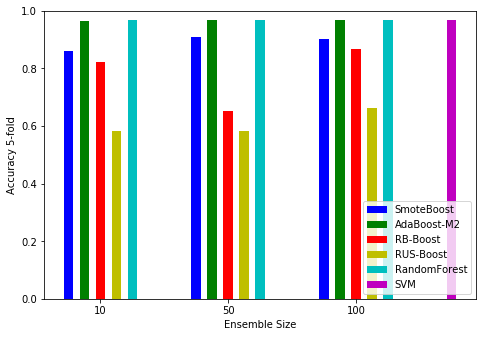

In [128]:
groups = 3
data = [[acc_smoteBoost_L10, acc_smoteBoost_L50, acc_smoteBoost_L100],
[acc_adaBoostM2_L10, acc_adaBoostM2_L50, acc_adaBoostM2_L100],
[acc_rbBoost_L10, acc_rbBoost_L50, acc_rbBoost_L100],
[acc_rusBoost_L10, acc_rusBoost_L50, acc_rusBoost_L100],
[acc_RF_L10, acc_RF_L50, acc_RF_L100],
]

X = np.arange(1, groups*2, step=2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])


ax.bar(X - 0.50, data[0], color = 'b', width = 0.15, label = 'SmoteBoost')
ax.bar(X - 0.25, data[1], color = 'g', width = 0.15, label = 'AdaBoost-M2')
ax.bar(X + 0.00, data[2], color = 'r', width = 0.15, label = 'RB-Boost')
ax.bar(X + 0.25, data[3], color = 'y', width = 0.15, label = 'RUS-Boost')
ax.bar(X + 0.50, data[4], color = 'c', width = 0.15, label = 'RandomForest')
ax.bar(6.5, acc_svm, color = 'm', width = 0.15, label = 'SVM')

plt.xticks(X, ('10', '50', '100'))
plt.xlabel('Ensemble Size')
plt.ylabel('Accuracy 5-fold')
plt.ylim(0,1)
plt.legend(loc='lower right')
plt.show()

## Precision

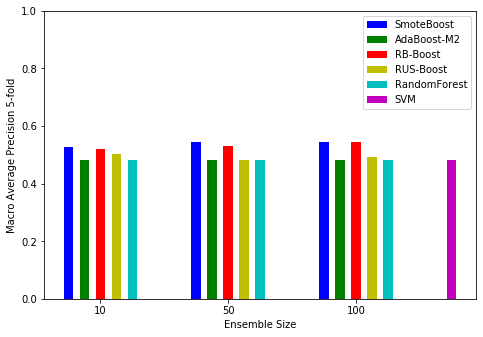

In [129]:
groups = 3
data = [[precision_smoteBoost_L10, precision_smoteBoost_L50, precision_smoteBoost_L100],
[precision_adaBoostM2_L10, precision_adaBoostM2_L50, precision_adaBoostM2_L100],
[precision_rbBoost_L10, precision_rbBoost_L50, precision_rbBoost_L100],
[precision_rusBoost_L10, precision_rusBoost_L50, precision_rusBoost_L100],
[precision_RF_L10, precision_RF_L50, precision_RF_L100],
]

X = np.arange(1, groups*2, step=2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])


ax.bar(X - 0.50, data[0], color = 'b', width = 0.15, label = 'SmoteBoost')
ax.bar(X - 0.25, data[1], color = 'g', width = 0.15, label = 'AdaBoost-M2')
ax.bar(X + 0.00, data[2], color = 'r', width = 0.15, label = 'RB-Boost')
ax.bar(X + 0.25, data[3], color = 'y', width = 0.15, label = 'RUS-Boost')
ax.bar(X + 0.50, data[4], color = 'c', width = 0.15, label = 'RandomForest')
ax.bar(6.5, precision_svm, color = 'm', width = 0.15, label = 'SVM')

plt.xticks(X, ('10', '50', '100'))
plt.xlabel('Ensemble Size')
plt.ylabel('Macro Average Precision 5-fold')
plt.ylim(0,1)
plt.legend(loc='upper right')
plt.show()

## Recall

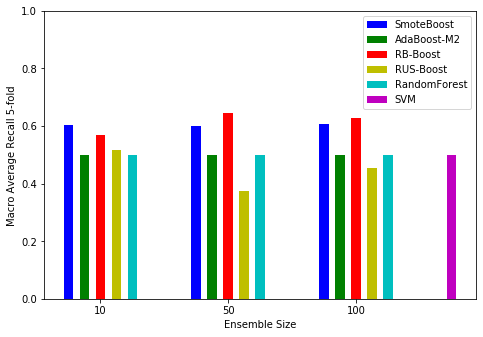

In [130]:
groups = 3
data = [[recall_smoteBoost_L10, recall_smoteBoost_L50, recall_smoteBoost_L100],
[recall_adaBoostM2_L10, recall_adaBoostM2_L50, recall_adaBoostM2_L100],
[recall_rbBoost_L10, recall_rbBoost_L50, recall_rbBoost_L100],
[recall_rusBoost_L10, recall_rusBoost_L50, recall_rusBoost_L100],
[recall_RF_L10, recall_RF_L50, recall_RF_L100],
]

X = np.arange(1, groups*2, step=2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])


ax.bar(X - 0.50, data[0], color = 'b', width = 0.15, label = 'SmoteBoost')
ax.bar(X - 0.25, data[1], color = 'g', width = 0.15, label = 'AdaBoost-M2')
ax.bar(X + 0.00, data[2], color = 'r', width = 0.15, label = 'RB-Boost')
ax.bar(X + 0.25, data[3], color = 'y', width = 0.15, label = 'RUS-Boost')
ax.bar(X + 0.50, data[4], color = 'c', width = 0.15, label = 'RandomForest')
ax.bar(6.5, recall_svm, color = 'm', width = 0.15, label = 'SVM')

plt.xticks(X, ('10', '50', '100'))
plt.xlabel('Ensemble Size')
plt.ylabel('Macro Average Recall 5-fold')
plt.ylim(0,1)
plt.legend(loc='upper right')
plt.show()